# Exogenous Uniswap Process modeling 


## Liquidity demand stochastic process

1. Acquire time series of order book for single collateral DAI 2017-2019; this is the proxy for the liquidity demand of RAI
2. Fit a parametric distribution to the data, resulting in a distribution $F^D_{RAI}(t;\mu_{RAI})$ and fitted parameters $\mu_{RAI}$.


To obtain this data, we ran a [Uniswap cadCAD model](https://github.com/cadCAD-org/demos/tree/master/demos/Multiscale/uniswap) twice, once to obtain Buy/Sell univariate time series data and once for obtaining univariate time series liquidity data. Shown below is the modification between runs. We then saved these runs as csv files and continue bring the data into this notebook for building stochastic generators.


```
# Mechanisms
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    # 1 Buy/Sell
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    # 2 Add/remove liquidity
#     if action == 'AddLiquidity':
#         return addLiquidity_DAI(params, step, history, current_state, input_)
#     elif action == 'Transfer':
#         return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', abs(current_state['DAI_balance']))
```

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd
from scipy.stats import gamma
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

## Data preprocessing

In [2]:
# import data
buy_sell_uniswap_events = pd.read_csv('data/uniswap_data_buy_sell.csv')
liquidity_uniswap_events = pd.read_csv('data/uniswap_liquidity_data.csv')

buy_sell_uniswap_events.head()

,Unnamed: 0,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep
0,1,5905000000000000000000,29974673940746674209,30000000000000000000,0,0,1,1,1
1,2,5907000000000000000000,29964555511671268196,30000000000000000000,0,0,1,1,2
2,3,5905035238623641640532,29974555511671268196,30000000000000000000,0,0,1,1,3
3,4,5903071785798411448958,29984555511671268196,30000000000000000000,0,0,1,1,4
4,5,5901109640216828255225,29994555511671268196,30000000000000000000,0,0,1,1,5


In [3]:
liquidity_uniswap_events.head()

,Unnamed: 0,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep
0,1,5900000000000000000000,29974673940746674209,30000000000000000000,0,0,1,1,1
1,2,5900000000000000000000,29964546939628433685,30000000000000000000,0,0,1,1,2
2,3,5900000000000000000000,29974546939628433685,30000000000000000000,0,0,1,1,3
3,4,5900000000000000000000,29984546939628433685,30000000000000000000,0,0,1,1,4
4,5,5900000000000000000000,29994546939628433685,30000000000000000000,0,0,1,1,5


<AxesSubplot:title={'center':'Dai liquidity univariate series'}, xlabel='timestep'>

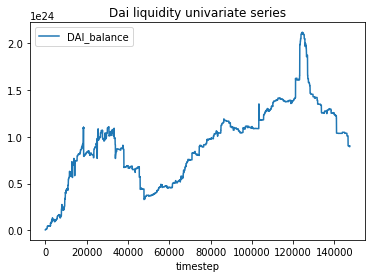

In [4]:
# liquidity series
liquidity_uniswap_events['DAI_balance'] = liquidity_uniswap_events['DAI_balance'].astype(float)
liquidity_uniswap_events.plot(x='timestep',y='DAI_balance',title='Dai liquidity univariate series')

<AxesSubplot:title={'center':'Dai liquidity univariate series'}, xlabel='timestep'>

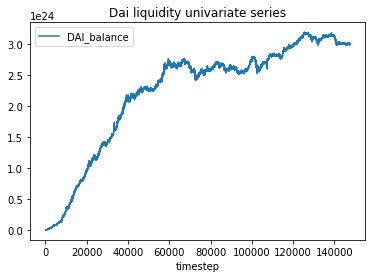

In [5]:
# buy/sell series
buy_sell_uniswap_events['DAI_balance'] = buy_sell_uniswap_events['DAI_balance'].astype(float)
buy_sell_uniswap_events.plot(x='timestep',y='DAI_balance',title='Dai liquidity univariate series')

## Distribution fitting

In [6]:
# fit liquidity distribution
fit_shape_liquidity, fit_loc_liquidity, fit_scale_liquidity =gamma.fit(liquidity_uniswap_events['DAI_balance'].values)


In [7]:
timesteps = 24 * 365 # 24 hours a day * 365 days a year 

Text(0.5, 1.0, 'Histogram of Liquidity IID Samples')

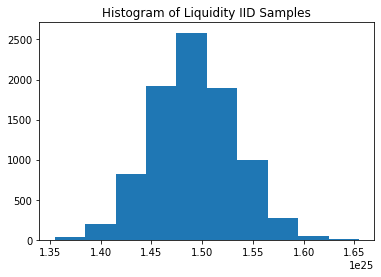

In [15]:
liquidity = np.random.gamma(fit_shape_liquidity, fit_scale_liquidity, timesteps)

plt.hist(liquidity)
plt.title('Histogram of Liquidity IID Samples')

Text(0.5, 1.0, 'Time Series of Liquidity IID Samples')

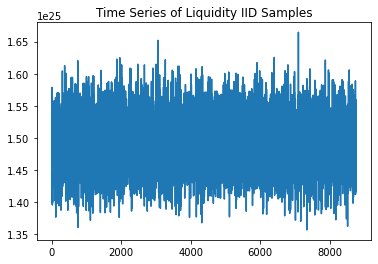

In [14]:
plt.plot(liquidity)
plt.title('Time Series of Liquidity IID Samples')

In [9]:
liquidity_samples = pd.DataFrame(liquidity,columns=['Liquidity_Samples'])
liquidity_samples.to_csv('data/liquidity_samples.csv')

In [10]:
# fit buy/sell series distribution
fit_shape_buy_sell, fit_loc_buy_sell, fit_scale_buy_sell = gamma.fit(buy_sell_uniswap_events['DAI_balance'].values)

Text(0.5, 1.0, 'Histogram of Buy Sell IID Samples')

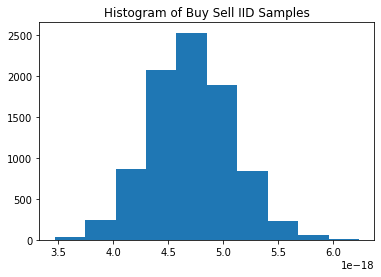

In [11]:
buy_sell = np.random.gamma(fit_shape_buy_sell, fit_scale_buy_sell, timesteps)
plt.hist(buy_sell)
plt.title('Histogram of Buy Sell IID Samples')

Text(0.5, 1.0, 'Time serires of Buy Sell IID Samples')

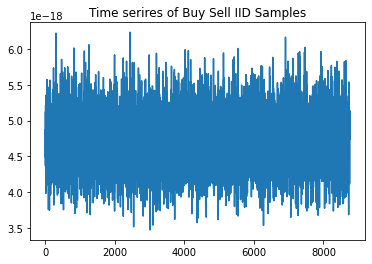

In [16]:
plt.plot(buy_sell)
plt.title('Time serires of Buy Sell IID Samples')

In [12]:
buy_sell_samples = pd.DataFrame(buy_sell,columns=['Buy_Sell_Samples'])
buy_sell_samples.to_csv('data/buy_sell.csv')

## Implementation information
Below is an example of how to integrate these univariate time series datasets into the exogenous process section of a cadCAD model, assuming each timestep is an hour.

```
# exogenousProcesses.py

# import libraries
import pandas as pd

# import data
liquidity_samples = pd.read_csv('data/liquidity_samples.csv')
buy_sell_samples = pd.read_csv('data/buy_sell.csv')

# mechanisms
def liquidity_exogenous_process(params, step, sL, s, _input):
    y = 'liquidity'
    timestep = s['timestep'] 
    x = liquidity_samples.Liquidity_Samples.values[timestep]
    return (y, x)
    
def buy_sell_exogenous_process(params, step, sL, s, _input):
    y = 'buy_sell'
    timestep = s['timestep'] 
    x = buy_sell_samples.Buy_Sell_Samples.values[timestep]
    return (y, x)
    
```